In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.6 MB/s eta 0:00:00


<Figure size 1000x1000 with 0 Axes>

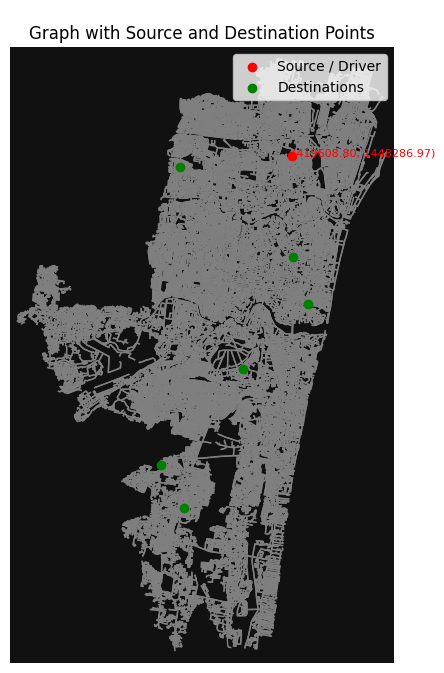

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Define the place to fetch the street network
place_name = "Chennai, Tamil Nadu, 600001, India"

# Fetch the street network
G = ox.graph_from_place(place_name, network_type='all')

# Project the graph to UTM
G = ox.project_graph(G)

# Get positions for the nodes
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Generate some random source and destination nodes
nodes = list(G.nodes)
num_sources = 1
num_destinations = 6
sources = np.random.choice(nodes, num_sources, replace=False)
destinations = np.random.choice(nodes, num_destinations, replace=False)

# Plot the graph
plt.figure(figsize=(10, 10))
ox.plot_graph(G, show=False, close=False, node_size=0, edge_color='gray')

# Plot source points in red
source_pos = {node: pos[node] for node in sources}
plt.scatter(*zip(*source_pos.values()), c='red', label='Source / Driver', zorder=5)

# Plot destination points in green
destination_pos = {node: pos[node] for node in destinations}
plt.scatter(*zip(*destination_pos.values()), c='green', label='Destinations', zorder=5)

# Add coordinates text to source points
for node, (x, y) in source_pos.items():
    plt.text(x, y, f"({x:.2f}, {y:.2f})", fontsize=8, color='red')


# Add legend and show plot
plt.legend()
plt.title('Graph with Source and Destination Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
!pip install ant_colony

<Figure size 1000x1000 with 0 Axes>

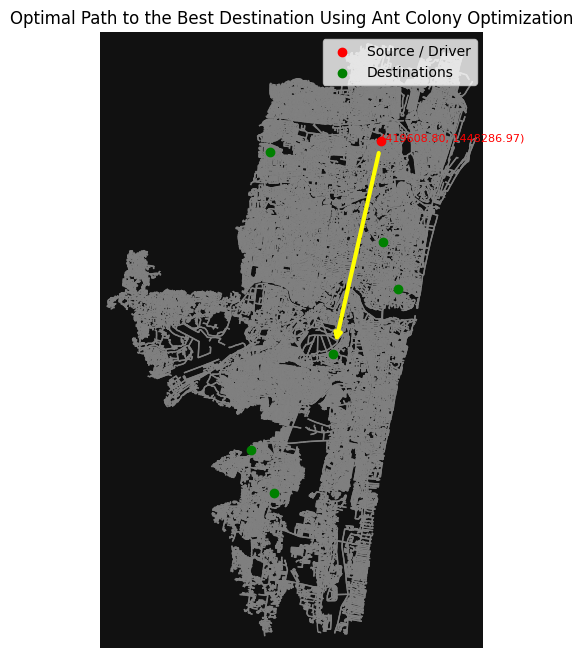

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

def distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

def ant_colony_optimization(G, pos, source, target, n_ants, n_iterations, alpha, beta, evaporation_rate, Q):
    nodes = [source, target]
    pheromone = np.ones((2, 2))
    best_path = None
    best_path_length = np.inf

    for iteration in range(n_iterations):
        path = [0]
        current_point = 0
        visited = [False, False]
        visited[current_point] = True
        path_length = 0

        for _ in range(1):
            next_point = 1
            path.append(next_point)
            path_length += distance(pos[nodes[current_point]], pos[nodes[next_point]])
            current_point = next_point

        if path_length < best_path_length:
            best_path = path
            best_path_length = path_length

        pheromone *= evaporation_rate
        pheromone[0, 1] += Q / path_length
        pheromone[1, 0] += Q / path_length

    return best_path, best_path_length, nodes

# Calculate distances between all destination nodes and determine the most clustered destination
def find_best_destination(pos, destinations, radius=0.01):
    best_node = None
    max_neighbors = -1

    for node in destinations:
        neighbors = sum(1 for other_node in destinations if distance(pos[node], pos[other_node]) <= radius)
        if neighbors > max_neighbors:
            max_neighbors = neighbors
            best_node = node

    return best_node

# Find the best destination node that is close to other destination nodes
best_destination = find_best_destination(pos, destinations)

# Ant Colony Optimization Parameters
n_ants = 10
n_iterations = 100
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
Q = 100

# Run Ant Colony Optimization from the source to the best destination
best_path, best_path_length, nodes = ant_colony_optimization(G, pos, sources[0], best_destination, n_ants, n_iterations, alpha, beta, evaporation_rate, Q)

# Extract the optimal path nodes
optimal_path_nodes = [nodes[i] for i in best_path]

# Plot the graph with the optimal path highlighted
plt.figure(figsize=(10, 10))
ox.plot_graph(G, show=False, close=False, node_size=0, edge_color='gray')

# Plot the optimal path in yellow
optimal_path_edges = list(zip(optimal_path_nodes[:-1], optimal_path_nodes[1:]))
optimal_path_pos = {node: pos[node] for node in optimal_path_nodes}
nx.draw_networkx_edges(G, pos, edgelist=optimal_path_edges, edge_color='yellow', width=3)

# Plot the source and destination points again
plt.scatter(*zip(*{node: pos[node] for node in sources}.values()), c='red', label='Source / Driver')
plt.scatter(*zip(*{node: pos[node] for node in destinations}.values()), c='green', label='Destinations')

# Add coordinates text to source points
for node, (x, y) in {node: pos[node] for node in sources}.items():
    plt.text(x, y, f"({x:.2f}, {y:.2f})", fontsize=8, color='red')

# Add legend and show plot
plt.legend()
plt.title('Optimal Path to the Best Destination Using Ant Colony Optimization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


<Figure size 1000x1000 with 0 Axes>

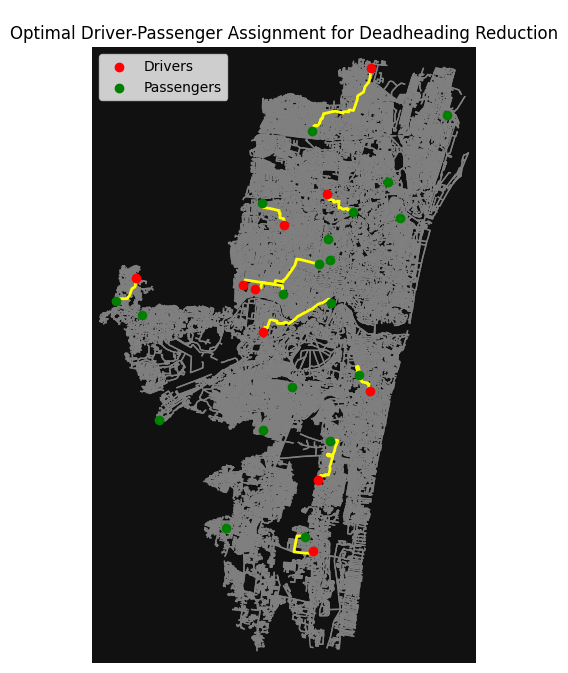

In [3]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Define the place to fetch the street network
place_name = "Chennai, Tamil Nadu, 600001, India"

# Fetch the street network
G = ox.graph_from_place(place_name, network_type='all')
G = ox.project_graph(G)
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Generate multiple sources (drivers) and destinations (passengers)
num_sources = 10  # Number of drivers
num_destinations = 20  # Number of passengers
sources = np.random.choice(list(G.nodes), num_sources, replace=False)
destinations = np.random.choice(list(G.nodes), num_destinations, replace=False)

# Function to calculate the total deadheading distance
def calculate_deadheading_cost(sources, destinations):
    cost_matrix = np.zeros((len(sources), len(destinations)))
    for i, source in enumerate(sources):
        for j, destination in enumerate(destinations):
            cost_matrix[i][j] = nx.shortest_path_length(G, source, destination, weight='length')
    return cost_matrix

# Use a simple assignment algorithm (e.g., Hungarian algorithm)
from scipy.optimize import linear_sum_assignment

cost_matrix = calculate_deadheading_cost(sources, destinations)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Plot the optimal assignments
plt.figure(figsize=(10, 10))
ox.plot_graph(G, show=False, close=False, node_size=0, edge_color='gray')

# Plot sources (drivers) in red and destinations (passengers) in green
source_pos = {node: pos[node] for node in sources}
destination_pos = {node: pos[node] for node in destinations}

plt.scatter(*zip(*source_pos.values()), c='red', label='Drivers', zorder=5)
plt.scatter(*zip(*destination_pos.values()), c='green', label='Passengers', zorder=5)

# Draw the optimal routes from drivers to passengers
for i in range(len(row_ind)):
    source = sources[row_ind[i]]
    destination = destinations[col_ind[i]]
    route = nx.shortest_path(G, source, destination, weight='length')
    route_coords = [pos[node] for node in route]
    route_lat, route_lon = zip(*route_coords)
    plt.plot(route_lat, route_lon, c='yellow', linewidth=2)

# Add legend and show plot
plt.legend()
plt.title('Optimal Driver-Passenger Assignment for Deadheading Reduction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
